## MACHINE LEARNING ASSIGNMENT 1
#### Classification task
#### Student: Vishnevskiy Mark

#### 1. Import libraries

In [367]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

#### 2. Load data

In [368]:
stream_df = pd.read_csv('./stream/train_data.csv')
stream_dft = pd.read_csv('./stream/test_data.csv')
stream_df.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


#### 3. Explore data

In [369]:
# import pandas_profiling

# profileReport = pandas_profiling.profile_report.ProfileReport(stream_df)
# profileReport.to_file('stream_report.html')

#### 4. Preprocessing

In [370]:
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.utils import resample

def preprocess_data(stream_df, stream_df_test = None):

    # encoding categorical values
    target_encoding = {'partial':1, 'off':0}
    stream_df['auto_fec_state'] = stream_df['auto_fec_state'].apply(lambda x : target_encoding.get(x))

    # ordinal encoding
    target_encoding = {'off':0., 'partial':0.5, 'full':1.}
    stream_df['auto_bitrate_state_lable'] = stream_df['auto_bitrate_state'].apply(lambda x : target_encoding.get(x))
    
    # one-hot encoding
    encoder = OneHotEncoder(cols=['auto_bitrate_state'], handle_unknown='error')
    encoder.fit(stream_df)
    stream_df = encoder.transform(stream_df)
    
    # removing outliers
    buf = stream_df['stream_quality']
    stream_df = stream_df.drop('stream_quality', axis=1)
    stream_df = stream_df[(np.abs(stats.zscore(stream_df)) < 3).all(axis=1)]
    stream_df['stream_quality'] = buf[stream_df.index]

    # data augmentation (data imbalance problem)
    df_major = stream_df[stream_df.stream_quality == 0]
    df_minor = stream_df[stream_df.stream_quality == 1]
    df_minor_sample = resample(df_minor, replace=True, n_samples=len(df_minor)*4)
    stream_df = pd.concat([df_major, df_minor_sample])

    # splitting into features and target
    y_train = stream_df['stream_quality']
    x_train = stream_df.drop(['stream_quality'], axis=1)

    # scaling data
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
    
    # same, but for test data (fitted on train data)
    if (not stream_df_test is None):
        target_encoding = {'partial':1, 'off':0}
        stream_df_test['auto_fec_state'] = stream_df_test['auto_fec_state'].apply(lambda x : target_encoding.get(x))

        target_encoding = {'off':0., 'partial':0.5, 'full':1.}
        stream_df_test['auto_bitrate_state_lable'] = stream_df_test['auto_bitrate_state'].apply(lambda x : target_encoding.get(x))
        
        stream_df_test = encoder.transform(stream_df_test)

        y_test = stream_df_test['stream_quality']
        x_test = stream_df_test.drop(['stream_quality'], axis=1)
        x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)
    return x_train, y_train, x_test, y_test


In [371]:
x_train, y_train, x_test, y_test = preprocess_data(stream_df, stream_dft)

#### 5. Feature selection

In [372]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(x_train, y_train)

In [373]:
coefs = np.array(ridge.coef_)
num_of_features = 8
indexes = sorted(range(len(coefs)), key=lambda k: -coefs[k])[:num_of_features]
selected_features = [x_train.columns.to_list()[i] for i in indexes]
print(selected_features)
x_train = x_train[selected_features]
x_test = x_test[selected_features]

['dropped_frames_std', 'fps_lags', 'dropped_frames_mean', 'rtt_std', 'fps_std', 'rtt_mean', 'auto_fec_state', 'auto_fec_mean']


#### 6. Data visualization

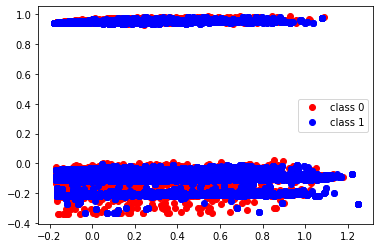

In [374]:
from sklearn.decomposition import PCA

dim_reducer = PCA(n_components=2)
x_train_2d = dim_reducer.fit_transform(x_train)

index_1 = np.where(y_train == 0)[0]
plt.plot(x_train_2d[index_1][:,1], x_train_2d[index_1][:,0], 'ro', label="class 0")
index_2 = np.where(y_train == 1)[0]
plt.plot(x_train_2d[index_2][:,1], x_train_2d[index_2][:,0], 'bo', label="class 1")

plt.legend()
plt.show()

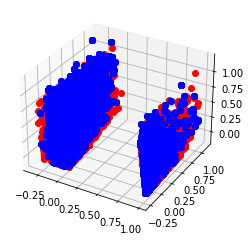

In [375]:
from mpl_toolkits import mplot3d
dim_reducer = PCA(n_components=3)
x_train_3d = dim_reducer.fit_transform(x_train)

ax = plt.axes(projection='3d')
index = np.where(y_train == 0)[0]
ax.plot3D(x_train_3d[index][:,0], x_train_3d[index][:,2], x_train_3d[index][:,1], 'ro', label="class 0")
index = np.where(y_train == 1)[0]
ax.plot3D(x_train_3d[index][:,0], x_train_3d[index][:,2], x_train_3d[index][:,1], 'bo', label="class 1")

#### 7. Machine learning

In [376]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

classificators = [LogisticRegression(C=1, penalty='l1', solver='liblinear'), LogisticRegression('l2'), GaussianNB()]
for clf in classificators:
    clf.fit(x_train, y_train)

predictions = [clf.predict(x_test) for clf in classificators]
predictions_train = [clf.predict(x_train) for clf in classificators]

In [377]:
results = {'Model':['LogReg l1', 'LogReg l2', 'NaiveBaies']}

results['Accuracy'] = [metrics.accuracy_score(y_test, y_pred) for y_pred in predictions]
results['Presicion'] = [metrics.precision_score(y_test, y_pred) for y_pred in predictions]
results['Recall'] = [metrics.recall_score(y_test, y_pred) for y_pred in predictions]
results['Mean Absolute Error'] = [metrics.mean_absolute_error(y_test, y_pred) for y_pred in predictions]
results['Mean Squared Error'] = [metrics.mean_squared_error(y_test, y_pred) for y_pred in predictions]
results['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_test, y_pred)) for y_pred in predictions]
results['Root Squared'] = [np.sqrt(abs(metrics.r2_score(y_test, y_pred))) for y_pred in predictions]

measures = pd.DataFrame(data=results)


results_train = {'Model':['LogReg l1', 'LogReg l2', 'NaiveBaies']}

results_train['Accuracy'] = [metrics.accuracy_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Presicion'] = [metrics.precision_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Recall'] = [metrics.recall_score(y_train, y_pred) for y_pred in predictions_train]
results_train['Mean Absolute Error'] = [metrics.mean_absolute_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Mean Squared Error'] = [metrics.mean_squared_error(y_train, y_pred) for y_pred in predictions_train]
results_train['Root Mean Squared Error'] = [np.sqrt(metrics.mean_squared_error(y_train, y_pred)) for y_pred in predictions_train]
results_train['Root Squared'] = [np.sqrt(abs(metrics.r2_score(y_train, y_pred))) for y_pred in predictions_train]

measures_train = pd.DataFrame(data=results_train)

In [378]:
measures

,Model,Accuracy,Presicion,Recall,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Root Squared
0,LogReg l1,0.919748,0.381070,0.393526,0.080252,0.080252,0.283287,0.575685
1,LogReg l2,0.919416,0.379338,0.394227,0.080584,0.080584,0.283874,0.580457
2,NaiveBaies,0.895938,0.309092,0.498025,0.104062,0.104062,0.322586,0.852309


In [379]:
measures_train

,Model,Accuracy,Presicion,Recall,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Root Squared
0,LogReg l1,0.844624,0.647508,0.208410,0.155376,0.155376,0.394178,0.304342
1,LogReg l2,0.844299,0.644196,0.207883,0.155701,0.155701,0.394589,0.308069
2,NaiveBaies,0.840273,0.556261,0.344118,0.159727,0.159727,0.399659,0.351031
